In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import datasets

In [3]:
data_train = pd.read_csv("titanic/train.csv")
data_test = pd.read_csv("titanic/test.csv")


In [4]:
data_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
data_train.info()

# In the original dataset the columns Age and Cabin concentrate the set of informations with the highest amount of null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


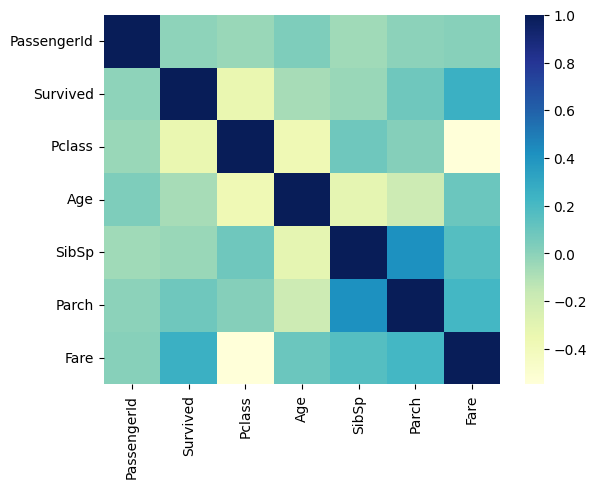

In [6]:
sns.heatmap(data_train.corr(numeric_only=True), cmap="YlGnBu")
pt.show()

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_ind, test_ind in split.split(data_train, data_train[["Survived", "Pclass", "Sex"]]):
  train_stratified = data_train.loc[train_ind]
  test_stratified = data_train.loc[test_ind]

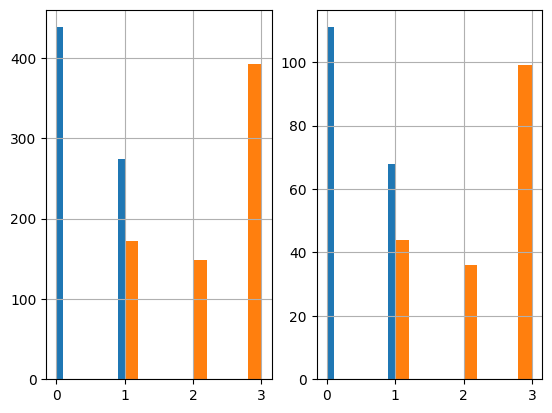

In [8]:
pt.subplot(1,2,1)
train_stratified['Survived'].hist()
train_stratified['Pclass'].hist()

pt.subplot(1,2,2)
test_stratified['Survived'].hist()
test_stratified['Pclass'].hist()

pt.show()

In [9]:
train_stratified.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 870 to 820
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          563 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        162 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    imputer = SimpleImputer(strategy="mean")
    X['Age'] = imputer.fit_transform(X[['Age']])
    return X

In [11]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    encoder = OneHotEncoder()
    matrix_embarked = encoder.fit_transform(X[['Embarked']]).toarray()
    matrix_sex = encoder.fit_transform(X[["Sex"]]).toarray()

    columns_encoded = ["C", "S", "Q", "N"]
    columns_encoded_sex = ["Female", "Male"]

    for i in range(len(matrix_embarked.T)):
      X[columns_encoded[i]] = matrix_embarked.T[i]
      
    for i in range(len(matrix_sex.T)):
      X[columns_encoded_sex[i]] = matrix_sex.T[i]
    
    return X




In [12]:
class FeatureDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    return X.drop(["Embarked", "Cabin", "Name", "Ticket", "Sex", "N"], axis=1, errors="ignore")

In [13]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
  ("ageimputer", AgeImputer()),
  ("featureencoder", FeatureEncoder()),
  ("featuredropper", FeatureDropper())
])

In [14]:
train_stratified = pipeline.fit_transform(train_stratified)
test_stratified = pipeline.fit_transform(test_stratified)

In [15]:
train_stratified

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
870,871,0,3,26.0,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
0,1,0,3,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
216,217,1,3,27.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
146,147,1,3,27.0,0,0,7.7958,0.0,0.0,1.0,0.0,1.0
575,576,0,3,19.0,0,0,14.5000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
117,118,0,2,29.0,1,0,21.0000,0.0,0.0,1.0,0.0,1.0
550,551,1,1,17.0,0,2,110.8833,1.0,0.0,0.0,0.0,1.0
586,587,0,2,47.0,0,0,15.0000,0.0,0.0,1.0,0.0,1.0
417,418,1,2,18.0,0,2,13.0000,0.0,0.0,1.0,1.0,0.0


In [16]:
train_stratified.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 870 to 820
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [17]:
from sklearn.preprocessing import StandardScaler

X = train_stratified.drop(["Survived"], axis=1)
y = train_stratified['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [18]:
X_test = test_stratified.drop(["Survived"], axis=1)
y_test = test_stratified['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [19]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(X_data, y_data)

In [20]:
clf

DecisionTreeClassifier()

In [21]:
clf.score(X_data_test, y_data_test)

0.7374301675977654

[Text(0.2940008892276423, 0.9705882352941176, 'x[10] <= -0.312\ngini = 0.473\nsamples = 712\nvalue = [438, 274]'),
 Text(0.12042682926829268, 0.9117647058823529, 'x[1] <= 0.229\ngini = 0.381\nsamples = 250\nvalue = [64, 186]'),
 Text(0.056910569105691054, 0.8529411764705882, 'x[2] <= -2.117\ngini = 0.098\nsamples = 136\nvalue = [7, 129]'),
 Text(0.04065040650406504, 0.7941176470588235, 'x[0] <= -0.117\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.032520325203252036, 0.7352941176470589, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.04878048780487805, 0.7352941176470589, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.07317073170731707, 0.7941176470588235, 'x[5] <= -0.07\ngini = 0.086\nsamples = 134\nvalue = [6, 128]'),
 Text(0.06504065040650407, 0.7352941176470589, 'x[5] <= -0.083\ngini = 0.188\nsamples = 57\nvalue = [6, 51]'),
 Text(0.056910569105691054, 0.6764705882352942, 'x[2] <= 2.092\ngini = 0.163\nsamples = 56\nvalue = [5, 51]'),
 Text(0.04065040650406504, 0.61764

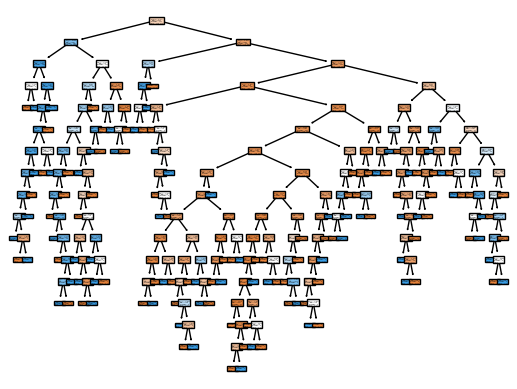

In [22]:
tree.plot_tree(clf, filled=True)

In [23]:
titanic_data = pipeline.fit_transform(data_train)

In [24]:
titanic_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [25]:
X_final = titanic_data.drop(["Survived"], axis=1)
y_final = titanic_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [26]:
final_clf = DecisionTreeClassifier()
final_clf = final_clf.fit(X_data_final, y_data_final)

[Text(0.36038442758413464, 0.9772727272727273, 'x[10] <= -0.309\ngini = 0.473\nsamples = 891\nvalue = [549, 342]'),
 Text(0.16856971153846154, 0.9318181818181818, 'x[1] <= 0.229\ngini = 0.383\nsamples = 314\nvalue = [81, 233]'),
 Text(0.05961538461538462, 0.8863636363636364, 'x[2] <= -2.093\ngini = 0.1\nsamples = 170\nvalue = [9, 161]'),
 Text(0.04038461538461539, 0.8409090909090909, 'x[1] <= -0.968\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.032692307692307694, 0.7954545454545454, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.04807692307692308, 0.7954545454545454, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.07884615384615384, 0.8409090909090909, 'x[5] <= -0.067\ngini = 0.091\nsamples = 168\nvalue = [8, 160]'),
 Text(0.06346153846153846, 0.7954545454545454, 'x[5] <= -0.08\ngini = 0.182\nsamples = 69\nvalue = [7, 62]'),
 Text(0.05576923076923077, 0.75, 'x[2] <= 2.024\ngini = 0.161\nsamples = 68\nvalue = [6, 62]'),
 Text(0.03461538461538462, 0.7045454545454546, 'x[0

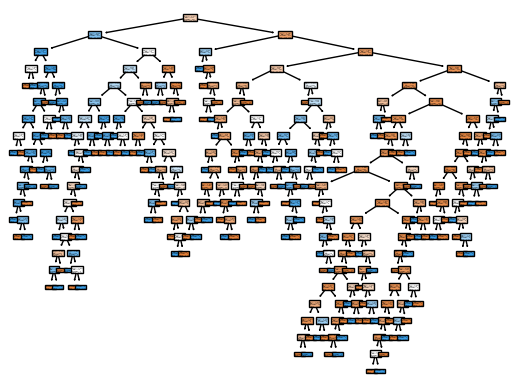

In [27]:
tree.plot_tree(final_clf, filled=True)

In [30]:
final_data_test = pipeline.fit_transform(data_test)

In [31]:
X_final_test = final_data_test.fillna(method="ffill")
scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

In [32]:
predict = final_clf.predict(X_data_final_test)

In [37]:
predict_df = pd.DataFrame(data_test["PassengerId"])
predict_df['Survived'] = predict
predict_df.to_csv("titanic/predictions.csv", index=False)

In [38]:
predict_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
